# Advanced Modeling of Groundwater Flow (GW3099)
![alt text](..\img\header.jpg)

# Exercise 5: MODFLOW 6
The purpose of this exercise is to use MODFLOW 6 to simulate example problem 1 using Flopy.

## Part I. Setup Notebook

In [1]:
from __future__ import print_function
%matplotlib inline
import sys
import os
import shutil
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy

import config

print(sys.version)
print('python executable: {}'.format(sys.executable))
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mf2005.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mp7.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mt3dms.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mf6.exe
Executable file found: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\gridgen.exe
3.6.6 | packaged by conda-forge | (default, Jul 26 2018, 11:48:23) [MSC v.1900 64 bit (AMD64)]
python executable: Z:\langevin\training\AdvancedModeling2018\gw3099\Miniconda3\python.exe
numpy version: 1.15.2
matplotlib version: 2.2.2
flopy version: 3.2.9


## Part II. Create, Run, and Post-Process MODFLOW 6 Model

In [2]:
# model info
model_name = 'ex05'
model_ws = './ex05-completed'

# grid properties
nlay = 3
nrow = 21
ncol = 20
delr = 500.
delc = 500.
top = 400.
botm = [220., 200., 0.]

# hydraulic properties
hk0 = 50.
vk0 = 10.
hk1 = 0.01
vk1 = 0.01
hk2 = 200.
vk2 = 20

## Part IIA. Create the Parent and Child Grids

In [3]:
from flopy.utils.lgrutil import Lgr
idomain = np.ones((nlay, nrow, ncol), dtype=np.int)
idomain[0:3, 8:14, 7:13] = 0
idomain[0:3, 7, 8:10] = 0
ncpp = 9
ncppl = 1
lgr = Lgr(nlay, nrow, ncol, delr, delc, top, botm,
            idomain, ncpp, ncppl)

In [4]:
# boundary conditions
welspd = [[(3 - 1, 11 - 1, 10 - 1), -1.5e5]]
rech = 0.005
rivspd = [[(0, ir, ncol-1), 320., 1.e5, 318.] for ir in range(nrow)]

In [5]:
# create simulation
sim = flopy.mf6.MFSimulation(sim_name=model_name, version='mf6', exe_name=config.mf6exe, 
                             sim_ws=model_ws)

# create tdis package
tdis_rc = [(1000.0, 1, 1.0)]
tdis = flopy.mf6.ModflowTdis(sim, pname='tdis', time_units='DAYS', 
                             perioddata=tdis_rc)

# create gwf model
gwf = flopy.mf6.ModflowGwf(sim, modelname=model_name,
                           model_nam_file='{}.nam'.format(model_name))
gwf.name_file.save_flows = True

# create iterative model solution and register the gwf model with it
ims = flopy.mf6.ModflowIms(sim, pname='ims', print_option='SUMMARY', 
                           complexity='SIMPLE', outer_hclose=1.e-5, 
                           outer_maximum=100, under_relaxation='NONE', 
                           inner_maximum=100, inner_hclose=1.e-6, 
                           rcloserecord=0.1, linear_acceleration='BICGSTAB', 
                           scaling_method='NONE', reordering_method='NONE', 
                           relaxation_factor=0.99)
sim.register_ims_package(ims, [gwf.name])

# dis
dis = flopy.mf6.ModflowGwfdis(gwf, nlay=nlay, nrow=nrow, ncol=ncol,
                              delr=delr, delc=delc,
                              top=top, botm=botm, idomain=idomain)

# initial conditions
ic = flopy.mf6.ModflowGwfic(gwf, pname='ic', strt=320.)

# node property flow
npf = flopy.mf6.ModflowGwfnpf(gwf, xt3doptions=[('xt3d')],
                              save_specific_discharge=True,
                              icelltype=[1,0,0], 
                              k=[50.0, 0.01, 200.0],
                              k33=[10., 0.01, 20.])

# rch
aux = [np.ones((nrow, ncol), dtype=np.int)*6]
rch = flopy.mf6.ModflowGwfrcha(gwf, recharge=0.005, 
                               auxiliary=[('iface',)], 
                               aux={0: [6]})
# riv
riv = flopy.mf6.ModflowGwfriv(gwf, stress_period_data=rivspd)

# output control
oc = flopy.mf6.ModflowGwfoc(gwf, pname='oc', budget_filerecord='{}.cbc'.format(model_name),
                            head_filerecord='{}.hds'.format(model_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# create child gwf model
cmodel_name = 'ex05c'
cgwf = flopy.mf6.ModflowGwf(sim, modelname=cmodel_name,
                           model_nam_file='{}.nam'.format(cmodel_name))
cgwf.name_file.save_flows = True
cnlay, cnrow, cncol = lgr.get_shape()
cdelr, cdelc = lgr.get_delr_delc()
ctop, cbotm = lgr.get_top_botm()
xorigin, yorigin = lgr.get_lower_left()
cidomain = lgr.get_idomain()
cdis = flopy.mf6.ModflowGwfdis(cgwf, nlay=cnlay, nrow=cnrow, ncol=cncol,
                               delr=cdelr, delc=cdelc,
                               top=ctop, botm=cbotm, idomain=cidomain,
                               xorigin=xorigin, yorigin=yorigin)
cic = flopy.mf6.ModflowGwfic(cgwf, pname='ic', strt=320.)
cnpf = flopy.mf6.ModflowGwfnpf(cgwf, xt3doptions=[('xt3d')],
                              save_specific_discharge=True,
                              icelltype=[1,0,0], 
                              k=[50.0, 0.01, 200.0],
                              k33=[10., 0.01, 20.])
# rch
aux = [np.ones((nrow, ncol), dtype=np.int)*6]
rch = flopy.mf6.ModflowGwfrcha(cgwf, recharge=0.005, 
                               auxiliary=[('iface',)], 
                               aux={0: [6]})
welspd = [[(cnlay - 1, int(cnrow / 2), int(cncol / 2)), -1.5e5]]
wel = flopy.mf6.ModflowGwfwel(cgwf, print_input=True,
                              stress_period_data=welspd)
oc = flopy.mf6.ModflowGwfoc(cgwf, pname='oc', budget_filerecord='{}.cbc'.format(cmodel_name),
                            head_filerecord='{}.hds'.format(cmodel_name),
                            headprintrecord=[('COLUMNS', 10, 'WIDTH', 15,
                                              'DIGITS', 6, 'GENERAL')],
                            saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                            printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')])

# exchange information
exchangedata = lgr.get_exchange_data(angldegx=True, cdist=True)
nexg = len(exchangedata)
gwfe = flopy.mf6.ModflowGwfgwf(sim, exgtype='gwf6-gwf6', exgmnamea='ex05', exgmnameb='ex05c', 
                               nexg=nexg, auxiliary=[('angldegx', 'cdist')], exchangedata=exchangedata)

sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model ex05...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
  writing model ex05c...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: Z:\langevin\training\AdvancedModeling2018\gw3099\gw3099_classrepo\exercises\bin\win64\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURV

(True, [])

In [6]:
def get_data(model_ws, model_name):
    # Load binary grid file
    fname = os.path.join(model_ws, model_name + '.dis.grb')
    grd = flopy.utils.MfGrdFile(fname, verbose=False)
    sr = grd.get_spatialreference()

    # load the heads and budget files
    fname = os.path.join(model_ws, model_name + '.hds')
    hdobj = flopy.utils.HeadFile(fname)
    head = hdobj.get_data()
    head = np.ma.masked_equal(head, 1e30)
    nlay = hdobj.nlay
    nrow = hdobj.nrow
    ncol = hdobj.ncol
    nodes = nlay * nrow * ncol

    fname = os.path.join(model_ws, model_name + '.cbc')
    cbb = flopy.utils.CellBudgetFile(fname, precision='double')
    spdis = cbb.get_data(text='DATA-SPDIS')[0]
    qx = np.ones((nodes), dtype=np.float) * 1.e30
    qy = np.ones((nodes), dtype=np.float) * 1.e30
    qz = np.ones((nodes), dtype=np.float) * 1.e30
    n0 = spdis['node'] - 1
    qx[n0] = spdis['qx']
    qy[n0] = spdis['qy']
    qz[n0] = spdis['qz']
    qx = qx.reshape(nlay, nrow, ncol)
    qy = qy.reshape(nlay, nrow, ncol)
    qz = qz.reshape(nlay, nrow, ncol)
    qx = np.ma.masked_equal(qx, 1.e30)
    qy = np.ma.masked_equal(qy, 1.e30)
    qz = np.ma.masked_equal(qz, 1.e30)
    return sr, head, qx, qy

In [7]:
def make_map(ax, ilay, sr, head, qx, qy, vmin=None, vmax=None, levels=None):
    quadmesh = sr.plot_array(head[ilay], ax)
    #quadmesh.set(edgecolor='k')
    quadmesh.set_clim(vmin=vmin, vmax=vmax)
    quadmesh.set(cmap='jet')
    contour_set = sr.contour_array(ax, head[ilay], levels=levels, colors='white')
    if qx is not None:
        quiver = ax.quiver(sr.xcentergrid, sr.ycentergrid, qx[ilay], qy[ilay])
    return

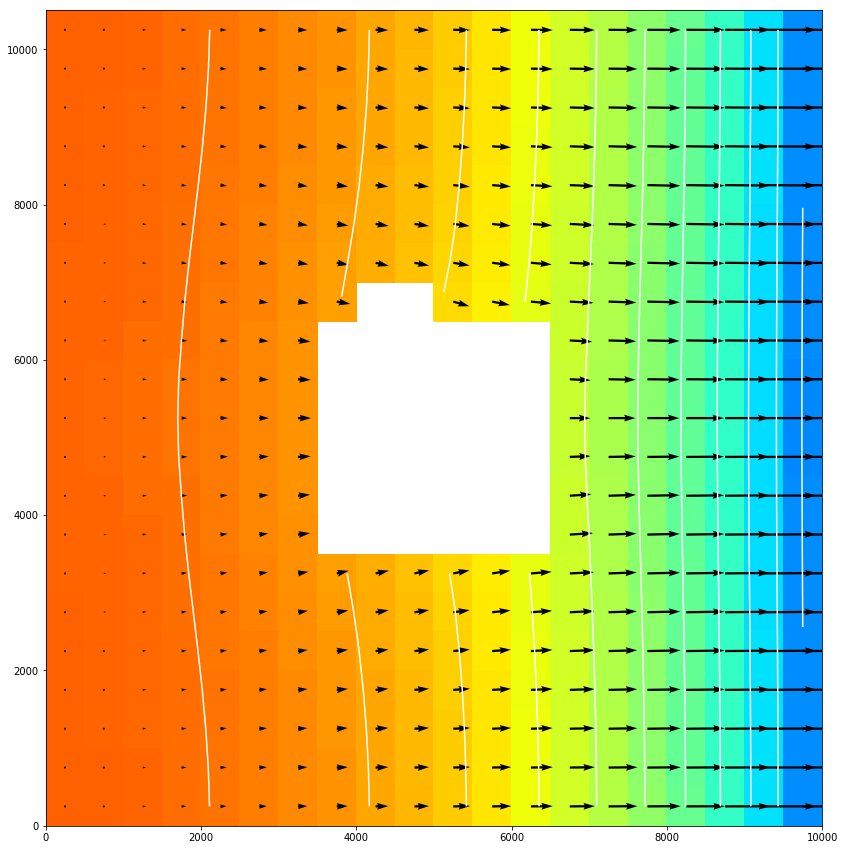

In [8]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')

ilay = 1

dp = get_data(model_ws, model_name)
dc = get_data(model_ws, cmodel_name)
vmin = min(dp[1].min(), dc[1].min())
vmax = max(dp[1].max(), dc[1].max())
levels = np.linspace(vmin, vmax, 20)

make_map(ax, ilay, *dp, vmin=vmin, vmax=vmax, levels=levels)
#make_map(ax, ilay, *dc, vmin=vmin, vmax=vmax, levels=levels)

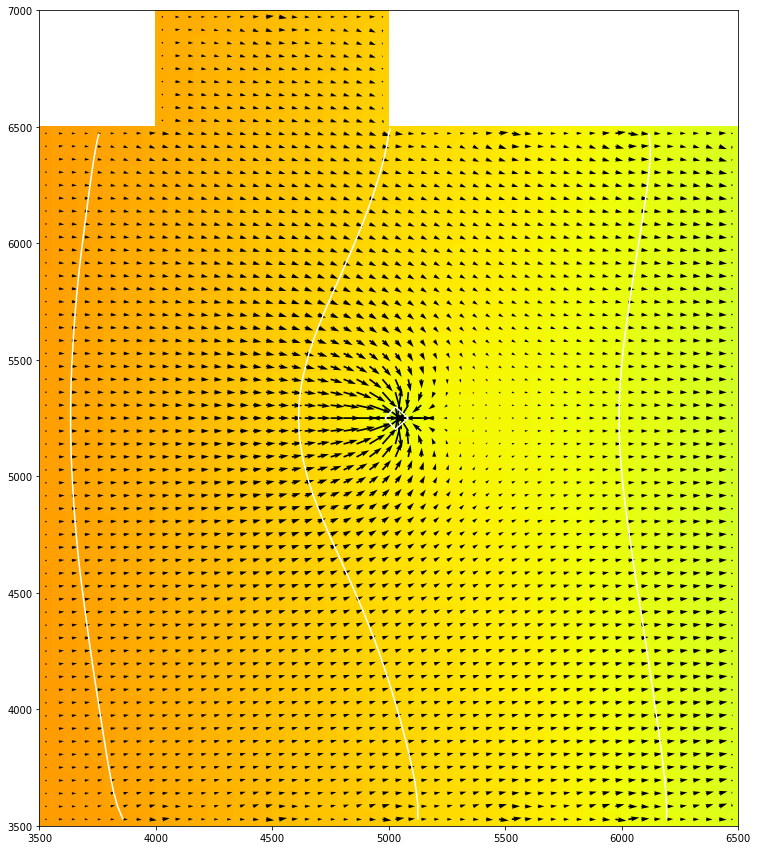

In [9]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')

ilay = 1

dp = get_data(model_ws, model_name)
dc = get_data(model_ws, cmodel_name)
vmin = min(dp[1].min(), dc[1].min())
vmax = max(dp[1].max(), dc[1].max())
levels = np.linspace(vmin, vmax, 20)

#make_map(ax, ilay, *dp, vmin=vmin, vmax=vmax, levels=levels)
make_map(ax, ilay, *dc, vmin=vmin, vmax=vmax, levels=levels)

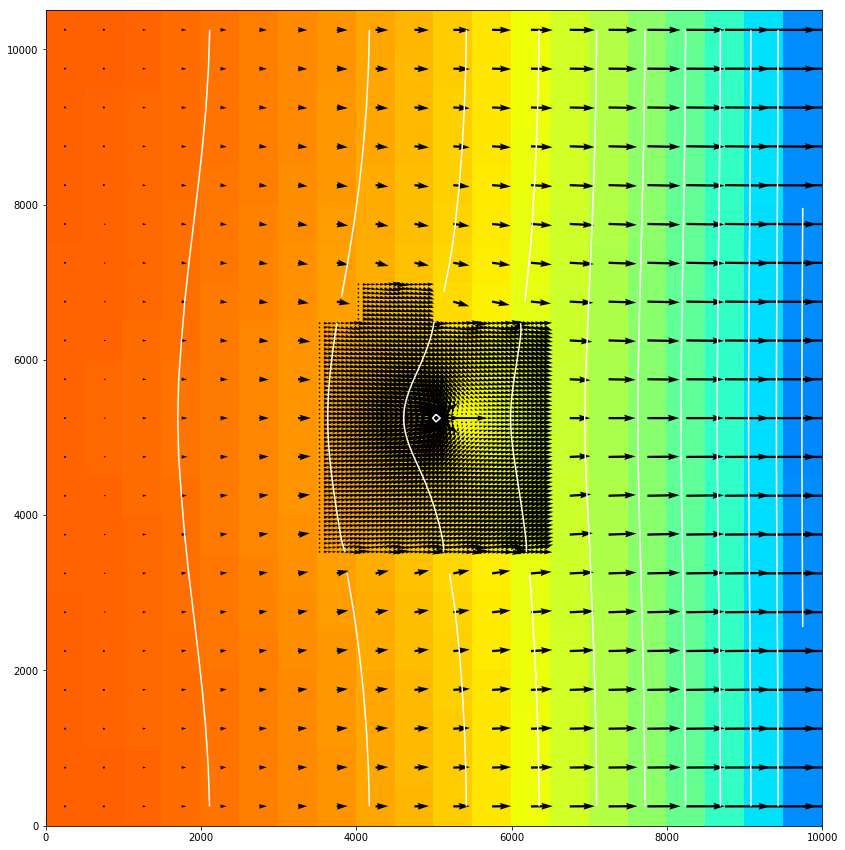

In [10]:
fig = plt.figure(figsize=(15, 15))
ax = plt.subplot(1, 1, 1, aspect='equal')

ilay = 1

dp = get_data(model_ws, model_name)
dc = get_data(model_ws, cmodel_name)
vmin = min(dp[1].min(), dc[1].min())
vmax = max(dp[1].max(), dc[1].max())
levels = np.linspace(vmin, vmax, 20)

make_map(ax, ilay, *dp, vmin=vmin, vmax=vmax, levels=levels)
make_map(ax, ilay, *dc, vmin=vmin, vmax=vmax, levels=levels)